<p align="center">
  <img src="https://img.shields.io/badge/Research%20Mode-ON-4cbb17?style=for-the-badge" alt="Research Mode">
</p>

# 01 · Getting Started — ASAP CRN Learning Lab  
*A guided launchpad for your first ASAP-CRN workspace adventure.*

Welcome to the **ASAP-CRN Learning Lab Pilot Workshop Series!**  

This notebook walks you through the essentials of workspace orientation and set up in **Verily Workbench**.

> **Tip:** Run each cell in order for the smoothest setup experience.  
> You can always come back later to experiment and make it your own.


In [1]:
import sys, subprocess, importlib, warnings, math, os, pandas as pd
from pathlib import Path

def setup_environment():
    """Configure logging, warnings, pandas options, and auto-install core packages."""

    def import_or_install(pkg, name=None):
        try:
            return importlib.import_module(name or pkg)
        except ImportError:
            print(f"{pkg} not found. Installing...")
            subprocess.run([sys.executable, "-m", "pip", "install", pkg], check=True)
            return importlib.import_module(name or pkg)

    env = {
        "pd": pd,
        "np": import_or_install("numpy"),
        "plt": import_or_install("matplotlib.pyplot", "matplotlib.pyplot"),
        "sns": import_or_install("seaborn"),
        "Image": import_or_install("PIL.Image", "PIL.Image"),
        "sc": import_or_install("scanpy")
    }
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 1200)
    
    print("Environment ready.")
    return env


In [2]:
env = setup_environment()
pd, np, plt, sns, Image, sc = (
    env["pd"], env["np"], env["plt"], env["sns"],
    env["Image"], env["sc"]
)

Environment ready.


# Table of Contents
1. [Workspace Orientation](#workspace-orientation)    
2. [Setting Project Paths](#setting-project-paths)
    - [2.1 Understanding the Path Components](#dataset-paths)
    - [2.2 Accessing Metadata](#analysis-output-files)
    - [2.3 Evaluating Curated Files](#metadata-files)
3. [Exploring a Dataset](#exploring-a-dataset)  
   - [3.1 Inspect QC Plots](#inspect-qc-plots)
   - [3.2 Copying Data Locally](#copying-data-locally)
   - [3.3 Preview Cell Metadata](#preview-cell-metadata)
   - [3.4 Preview Anndata Object](#preview-anndata)
4. [Reproducibility Notes](#reproducibility-notes)  
5. [Provenance](#provenance)  
6. [Next Steps](#next-steps)  

## 1. Workspace Orientation

In the **ASAP-CRN Learning Lab** workspace, data and resources are mounted under your home directory, typically:

- `~/workspace/` – workspace mount for data and outputs  
- `~/workspace/*/asap-curated-team/` – team-specific curated and derived datasets
- `~/workspace/*/asap-curated-cohort/` – multi-team curated and derived datasets  
- `~/workspace/ws_files/` – your personal scratch space for files and results  

General subfolders: 
- `~/cohort_analysis` - Processed cohort-level outputs
- `~/preprocess` - Intermediate files from data curation outputs
In this section, we’ll confirm these paths and see what’s available.

In [3]:
#set general folder paths
HOME = Path.home()
WS_ROOT = HOME / "workspace"
DATA_DIR = WS_ROOT / "Data"
WS_FILES = WS_ROOT / "ws_files"

if not WS_ROOT.exists():
    print(f"{WS_ROOT} doesn't exist. We need to remount our resources")
    !wb resource mount    

print("Home directory:     ", HOME)
print("Workspace root:     ", WS_ROOT)
print("Data directory:     ", DATA_DIR)
print("ws_files directory: ", WS_FILES)

print("\nContents of workspace root:")
for p in WS_ROOT.glob("*"):
    print(" -", p.name, "/" if p.is_dir() else "")

Home directory:      /home/jupyter
Workspace root:      /home/jupyter/workspace
Data directory:      /home/jupyter/workspace/Data
ws_files directory:  /home/jupyter/workspace/ws_files

Contents of workspace root:
 - Documentation /
 - ws_files /
 - 01_PMDBS_scRNAseq /
 - 02_PMDBS_bulkRNAseq /
 - 05_Other_Datasets /
 - 03_PMDBS_Spatial /
 - release_resources /
 - 04_Mouse_Spatial /


## 2. Setting Project Paths

For the next steps, we will work with datasets processed using the **PMDBS scRNAseq** workflow. Specifically, we will focus on the **cohort-level dataset**: `asap-cohort-pmdbs-sc-rnaseq`.  

This dataset represents a multi-dataset integration: samples from **five contributing datasets**, processed, curated, and harmonized into a single cohort resource.

### 2.1 Understanding the Path Components
The dataset paths follow a structured hierarchy. Each component has a specific meaning:

- **`workflow`** — identifies the workflow used for aggregation and integration.  
  Here we use the **[PMDBS scRNAseq workflow](https://github.com/ASAP-CRN/pmdbs-sc-rnaseq-wf)**.

- **`dataset_team`** — identifies the contributing team or grouping of datasets. For cohort-level analyses, this value is **`cohort`**, indicating multiple datasets combined.

- **`source`** — describes the biological source of the samples.  
  In this case, **`pmdbs`** refers to *post-mortem–derived brain samples*.

- **`dataset_type`** — describes the type of data generated.  
  Here it is **`sc-rnaseq`**, indicating single-cell RNA sequencing.

- **`bucket_name`** — the Google Cloud Storage bucket containing the curated dataset.

- **`dataset_name`** — a unique identifier for each curated dataset or collection.


In [4]:
## Build and set path to desired dataset

DATASETS_PATH = WS_ROOT / "01_PMDBS_scRNAseq"

workflow       = "pmdbs_sc_rnaseq"
dataset_team   = "cohort"
dataset_source = "pmdbs"
dataset_type   = "sc-rnaseq"

bucket_name  = f"asap-curated-{dataset_team}-{dataset_source}-{dataset_type}"
dataset_name = f"asap-{dataset_team}-{dataset_source}-{dataset_type}"

dataset_path = DATASETS_PATH / bucket_name / workflow
print("Dataset Path:", dataset_path)

Dataset Path: /home/jupyter/workspace/01_PMDBS_scRNAseq/asap-curated-cohort-pmdbs-sc-rnaseq/pmdbs_sc_rnaseq


## 2.2 Accessing Metadata Files

Metadata for each dataset is located within the `release_resources` directory. This folder contains tables describing samples, subjects, brain regions, and experimental conditions. See the [Data Dictionary](https://storage.googleapis.com/asap-public-assets/wayfinding/ASAP-CRN-Cloud-Data-Dictionary.pdf) for an overview of the metadata tables. 


> **Note:**  
> Metadata files are organized using the **short `dataset_name`**, not the `bucket_name`.  
> You can always use the File Browser tab of the side panel to explore directories and right-click any folder or file to copy its full path.


In [5]:
#Define metadata folder path
ds_metadata_path = WS_ROOT / "release_resources/cohort-pmdbs-sc-rnaseq/metadata"

#preview contents
!ls {ds_metadata_path} 

ASSAY_RNAseq.csv  collection_version  PMDBS.csv     STUDY.csv
cde_version	  CONDITION.csv       PROTOCOL.csv  SUBJECT.csv
CLINPATH.csv	  DATA.csv	      SAMPLE.csv


In [6]:
# preview a dataset metadata file 
display(pd.read_csv(ds_metadata_path / "CONDITION.csv", index_col=0).head(10))

,ASAP_team_id,ASAP_dataset_id,condition_id,intervention_name,intervention_id,protocol_id,intervention_aux_table
0,TEAM_HAFLER,DS_PMDBS_0002,Control,Case-Control,NaN,NaN,NaN
1,TEAM_HAFLER,DS_PMDBS_0002,PD,Case-Control,NaN,NaN,NaN
2,TEAM_LEE,DS_PMDBS_0001,Control,Case-Control,NaN,NaN,NaN
3,TEAM_LEE,DS_PMDBS_0001,PD,Case-Control,NaN,NaN,NaN
4,TEAM_JAKOBSSON,DS_PMDBS_0004,PD,Case-Control,Case,NaN,NaN
5,TEAM_JAKOBSSON,DS_PMDBS_0004,Control,Case-Control,Control,NaN,NaN
6,TEAM_SCHERZER,DS_PMDBS_0005,NaN,Case-Control,Case,NaN,NaN
7,TEAM_SCHERZER,DS_PMDBS_0005,NaN,Case-Control,Control,NaN,NaN
8,TEAM_SCHERZER,DS_PMDBS_0005,NaN,Case-Control,Other,NaN,NaN
9,TEAM_HARDY,DS_PMDBS_0003,PD,Case-Control,NaN,NaN,NaN


### 2.3 Inspecting Curated Files

Now that our path components are defined, we can inspect the curated files available in the cohort_analysis directory.

In [7]:
# Build the folder path to the cohort analysis directory
cohort_analysis_path = dataset_path / "cohort_analysis"

# Preview the directory contents
print("Contents of cohort_analysis:")
!ls {cohort_analysis_path}

# Optional pure-Python preview:
# [f.name for f in cohort_analysis_path.glob("**/*") if f.is_file()]

Contents of cohort_analysis:
asap-cohort.all_genes.csv
asap-cohort.doublet_score.violin.png
asap-cohort.features.umap.png
asap-cohort.final.h5ad
asap-cohort.final_metadata.csv
asap-cohort.groups.umap.png
asap-cohort.hvg_genes.csv
asap-cohort.merged_cleaned_unfiltered.h5ad
asap-cohort.mmc_otf_mapping.SEAAD.extended_results.json
asap-cohort.mmc_otf_mapping.SEAAD.log.txt
asap-cohort.mmc_otf_mapping.SEAAD.results.csv
asap-cohort.mmc_results.parquet
asap-cohort.n_genes_by_counts.violin.png
asap-cohort.pct_counts_mt.violin.png
asap-cohort.pct_counts_rb.violin.png
asap-cohort.sample_list.tsv
asap-cohort.scanvi_cell_types.parquet
asap-cohort.scanvi_model.tar.gz
asap-cohort.scib_report.csv
asap-cohort.scib_results.svg
asap-cohort.scvi_model.tar.gz
asap-cohort.total_counts.violin.png
MANIFEST.tsv


## 3. Exploring a Dataset

With the directory structure in place, we can begin exploring the processed outputs produced by the PMDBS scRNA-seq workflow.

### 3.1 Inspect QC Plots

The curated dataset includes several **QC violin plots** summarizing key metrics (e.g., doublet score, gene counts, mitochondrial content). Let’s load and display all violin plot images found in the folder.

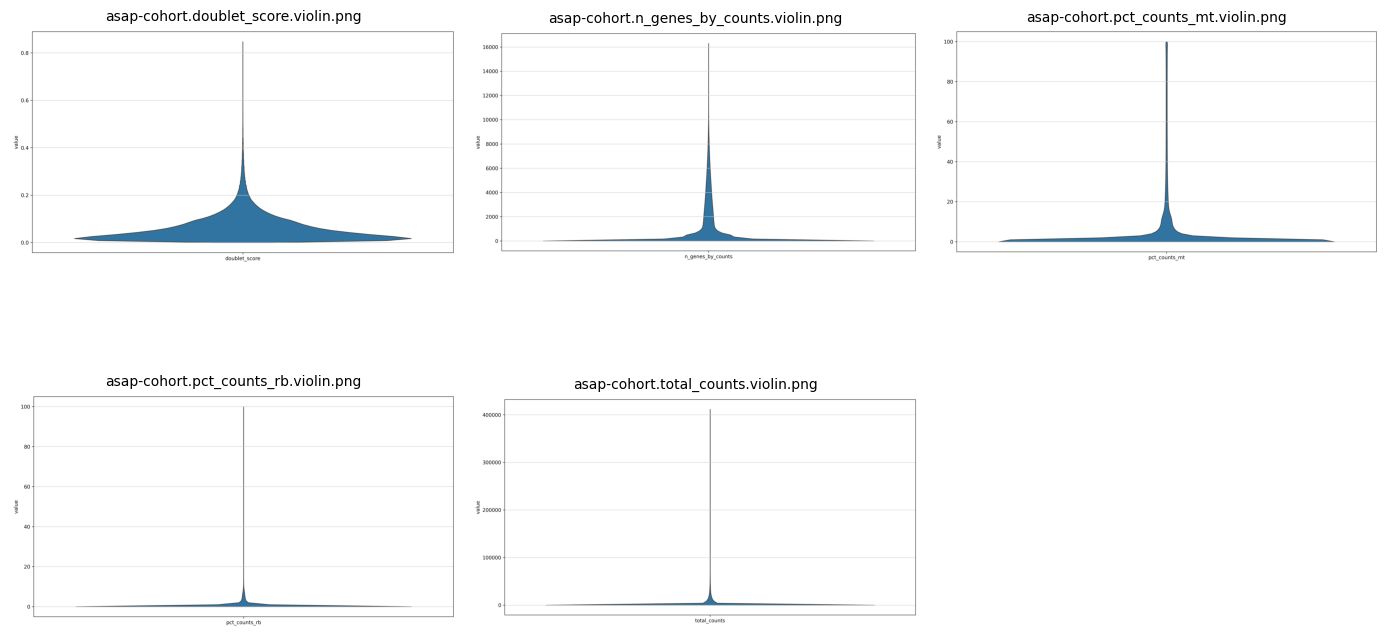

In [8]:
# Find all violin plot images
images = [
    os.path.join(cohort_analysis_path, f)
    for f in os.listdir(cohort_analysis_path)
    if f.lower().endswith("violin.png")
]

n = len(images)
if n == 0:
    print("No violin plots found in cohort_analysis.")
else:
    cols = 3
    rows = math.ceil(n / cols)

    plt.figure(figsize=(14, 4 * rows))

    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path), fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

### 3.2 Downloading data files locally

In this step, we’ll set up a local directory inside our JupyterLab environment to store data files.  The `ws_files` area is a scratch space tied to your workspace — anything saved here can be accessed later in the notebook, processed with Python, or uploaded back to a workspace bucket for sharing.

We’ll create a folder called `workshop_files` under our workspace path (`WS_PATH`).  This ensures that all downloaded datasets are organized in one place.

In [9]:
# Define a local path for workshop files
local_data_path = WS_FILES / "pilot_workshop_files"

# Create the directory if it doesn't already exist
if not local_data_path.exists():
    local_data_path.mkdir(parents=True)

print(f"Local data directory ready at: {local_data_path}")


Local data directory ready at: /home/jupyter/workspace/ws_files/pilot_workshop_files


We can now download the curated `anndata object` and it's associated `obs` field locally into our workspace.
> **Tip:**
> Pull the files into your local workspace first! It is much faster to load from local storage than from remote buckets.

In [10]:
# Downloading obs field (cell metadata)
# Define the expected local path for the metadata file.
cell_metadata_local_path = local_data_path / f"asap-{dataset_team}.final_metadata.csv"\

# Check if the metadata file already exists locally.
if not cell_metadata_local_path.exists():
    # Construct the original path where the metadata file is stored.
    cell_metadata_og_path = cohort_analysis_path / f"asap-{dataset_team}.final_metadata.csv"

    # Use a shell command (`cp`) to copy the file from the original location
    # into the local workshop_files directory for analysis.
    !cp {cell_metadata_og_path} {cell_metadata_local_path}

In [11]:
# Downloading the anndata object
# Define the expected local path
adata_local_path = local_data_path / f"asap-{dataset_team}.final.h5ad"

# Check if the adata file already exists locally.
if not adata_local_path.exists():
    # Construct the original path where the metadata file is stored.
    adata_cell_metadata_og_path = cohort_analysis_path / f"asap-{dataset_team}.final.h5ad"

    # Use a shell command (`cp`) to copy the file from the original location
    # into the local workshop_files directory for analysis.
    !cp {adata_cell_metadata_og_path} {adata_local_path}

### 3.3 Exploring the Cell Metadata

Once the data is available in our local `workshop_files` directory, we can begin exploring its metadata.

This field provides a compact entry point into the dataset’s metadata, making it easier to explore without handling the full expression matrix.

Each row in `obs` corresponds to a single cell (identified by a unique *barcode*) and contains:

- **Quality control metrics**: e.g. CellBender `cell_probability`, `n_genes_by_counts`, `total_counts`.  
- **Dataset references**: e.g. `sample`, `batch`, `team`, `dataset`.  
- **Downstream analysis results**: e.g. `UMAP_1`, `UMAP_2`, CellAssign `cell_type`, and Leiden cluster assignments.  

Together, these annotations summarize the key observations for each cell and provide a rich foundation for both quality assessment and downstream biological interpretation..


In [12]:
# load the adata object metadata
cell_metadata_df = pd.read_csv(cell_metadata_local_path, low_memory=False)
print(f"We have loaded the cell_metadata for N={cell_metadata_df.shape[0]} cells")
# Preview the contents 
cell_metadata_df.columns.to_list()

We have loaded the cell_metadata for N=3046127 cells


['Unnamed: 0',
 'background_fraction',
 'cell_probability',
 'cell_size',
 'droplet_efficiency',
 'n_genes_by_counts',
 'total_counts',
 'total_counts_rb',
 'pct_counts_rb',
 'total_counts_mt',
 'pct_counts_mt',
 'doublet_score',
 'sample',
 'batch',
 'team',
 'dataset',
 'batch_id',
 'S_score',
 'G2M_score',
 'phase',
 'cell_type',
 'phenotype',
 'rho',
 'prob',
 'class_name',
 'subclass_name',
 'supertype_name',
 '_scvi_batch',
 '_scvi_labels',
 'C_scANVI',
 'leiden_res_0.05',
 'leiden_res_0.10',
 'leiden_res_0.20',
 'leiden_res_0.40',
 'UMAP_1',
 'UMAP_2']

In [13]:
cell_metadata_df["cell_type"].value_counts()

cell_type
Unknown            938724
Glutamatergic      870959
Oligodendrocyte    487741
GABAergic          325943
Astrocyte          199467
Microglia-PVM       93236
OPC                 82791
Endothelial         26807
VLMC                20459
Name: count, dtype: int64

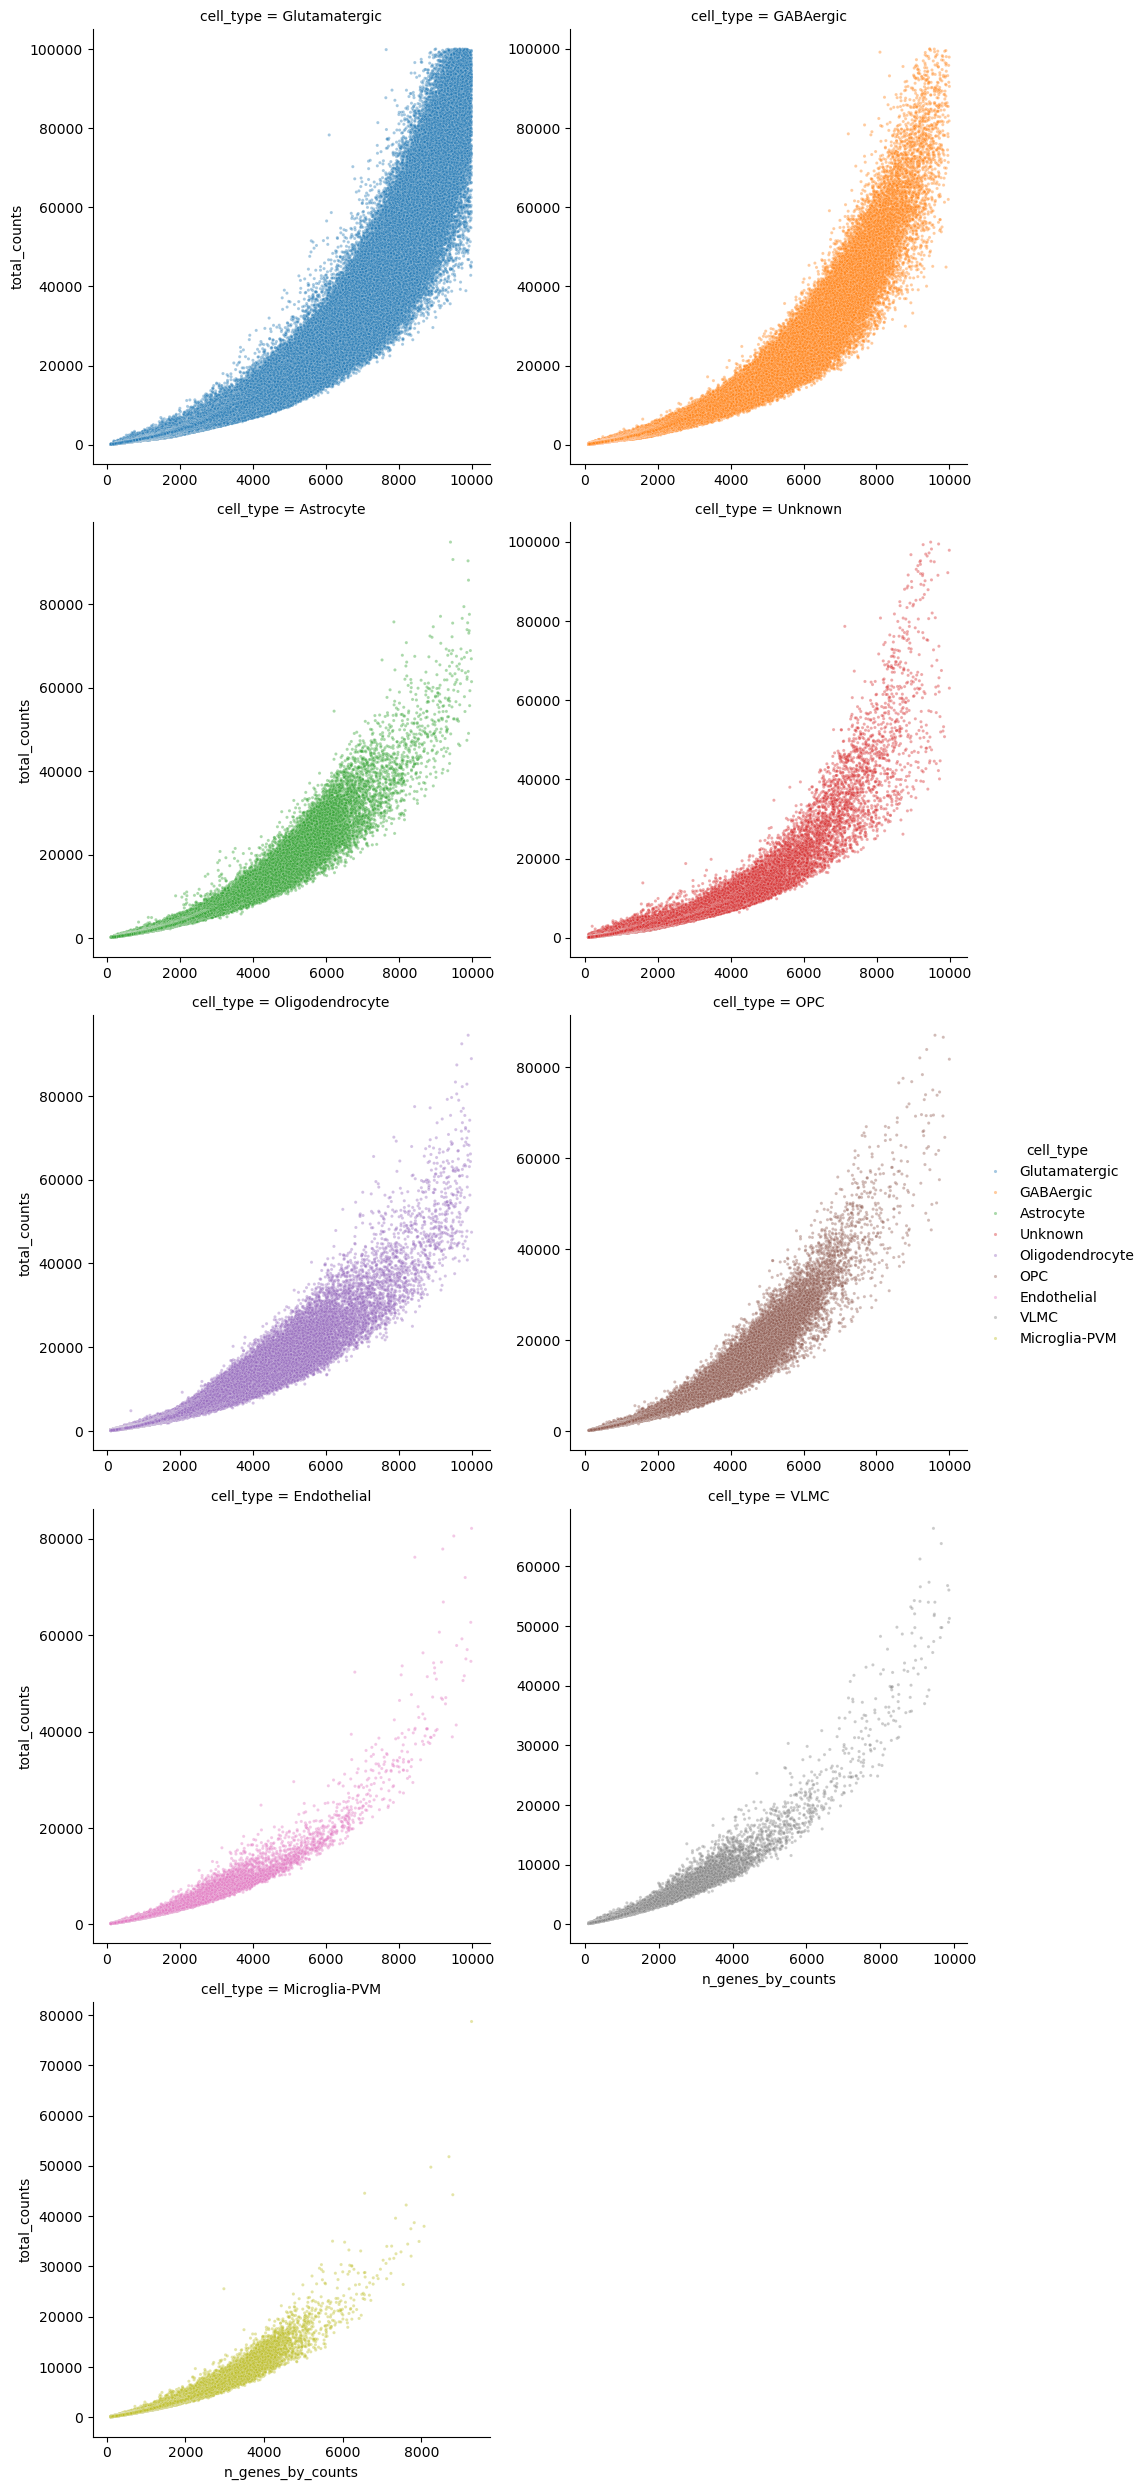

In [14]:
sns.relplot(
    data=cell_metadata_df,
    x="n_genes_by_counts",
    y="total_counts",
    col="cell_type",
    col_wrap=2,
    hue="cell_type",
    s=5,
    alpha=0.4,
    facet_kws=dict(sharex=False, sharey=False)
)


### 3.4 Exploring the AnnData

With the curated dataset stored locally, we can load it into memory using the `scanpy` library.  The data is stored in an **AnnData** object (`.h5ad` format), which is a common structure for single‑cell analysis.  

AnnData organizes the dataset into:
- **`.X`** → the main data matrix (e.g., gene expression counts).  
- **`.obs`** → per‑cell annotations (metadata such as QC metrics, sample IDs, cell types).  
- **`.var`** → per‑feature annotations (metadata about genes/features).  
- **`.uns`** → unstructured annotations (analysis results, parameters, plots).  

We’ll load the file in *backed mode* (`backed="r"`), which allows us to access the object without reading the entire matrix into memory. This is recommended for handling large datasets. 

In [15]:
# Load the curated AnnData object in backed mode
adata = sc.read_h5ad(adata_local_path, backed="r")

# Display a summary of the AnnData object
adata

AnnData object with n_obs × n_vars = 3046127 × 3000 backed at '/home/jupyter/workspace/ws_files/pilot_workshop_files/asap-cohort.final.h5ad'
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', 'cell_type', 'phenotype', 'rho', 'prob', 'class_name', 'subclass_name', 'supertype_name', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'log1p', 'neighbors', 'pca', 'scr

The above summary shows the number of cells (rows) and genes (columns), along with available annotations.  We can see that our `adata` object contains the cell-wise metadata in the `adata.obs` field, and gene-wise metadata in `adata.var`.  This `*.final_adata.h5ad` file contains only the top 3000 highly-variable genes.

Next, let’s visualize the dataset using a UMAP embedding to explore how cells are distributed by their assigned cell type and phase.


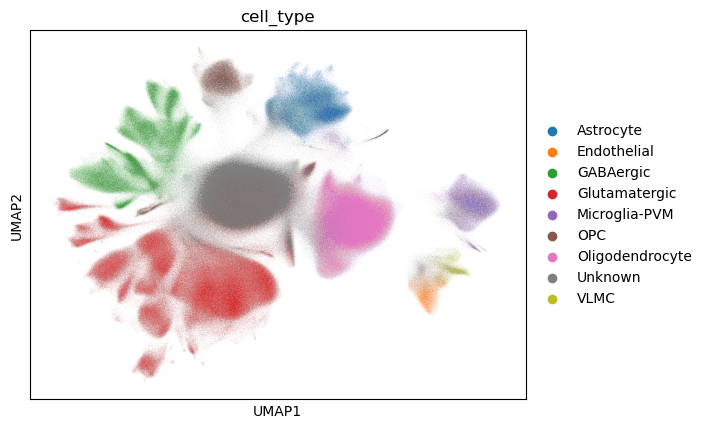

In [16]:
# Plot a UMAP embedding colored by cell type
sc.pl.embedding(adata, basis="umap", color=["cell_type"])


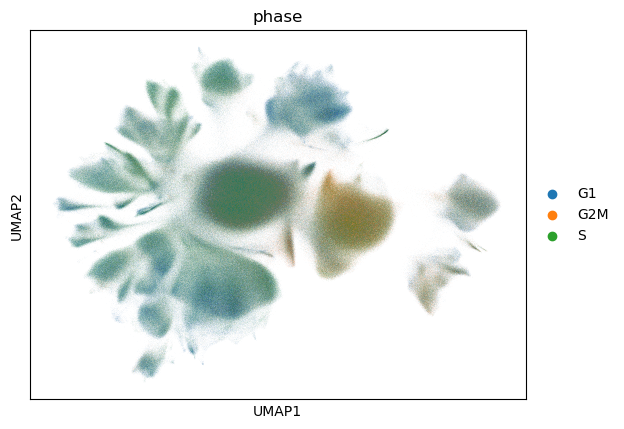

In [17]:
# Plot a UMAP embedding colored by phase
sc.pl.embedding(adata, basis="umap", color=["phase"])

## 4. Reproducibility / Versioning Notes

To keep analyses reproducible and collaborative:

- **Record environment details**: note Python version and key package versions (`scanpy`, `pandas`, etc.).
- **Save intermediate outputs**: store curated files and metadata snapshots in `ws_files`.
- **Use Git for version control**: commit notebooks and scripts to a shared repository.
- **Document changes**: add notes in Markdown cells or a changelog section at the end of the notebook.

These practices make it easier for collaborators (and your future self) to reproduce results.


## 5. Provenance

This notebook was generated as part of the **ASAP-CRN Verily Workbench Learning Lab** to demonstrate workspace orientation using harmonized single-nucleus RNA-seq data from the ASAP Collaborative Research Network.

### **Software & Environment**
- Platform: **Verily Workbench**
- Runtime: Cloud app environment - Jupyter Lab (Python)
- Key libraries: `scanpy`, `anndata`, `pandas`, `numpy`, `matplotlib`, `seaborn`
- Data format: `AnnData` (`.h5ad`)

### **Source Data**
The dataset analyzed here originates from the integrated ASAP CRN post-mortem brain cohort:

- Curation Workflow: **PMDBS scRNAseq Pipeline**  
- Data type: **cohort-level harmonized single-nucleus RNA-seq**
- Input samples: Multiple contributing datasets aggregated into a shared latent space
- Data storage:
  - Harmonized cohort files: `workspace/01_PMDBS_scRNAseq/asap-curated-cohort-pmdbs-sc-rnaseq/pmdbs_sc_rnaseq/cohort_analysis`

Full metadata tables used:
- `SAMPLE.csv` — sample-level descriptors
- `SUBJECT.csv` — donor/demographic attributes
- `PMDBS.csv` — brain-region annotations
- `CONDITION.csv` — experimental condition annotations

### **Notebook-Generated Outputs**
This notebook produces intermediate artifacts stored locally under: `ws_files/pilot_workshop_files/`

In [18]:
!conda env export

name: base
channels:
  - conda-forge
dependencies:
  - _libgcc_mutex=0.1=conda_forge
  - _openmp_mutex=4.5=2_gnu
  - archspec=0.2.5=pyhd8ed1ab_0
  - boltons=25.0.0=pyhd8ed1ab_0
  - brotli-python=1.1.0=py312h2ec8cdc_3
  - bzip2=1.0.8=h4bc722e_7
  - c-ares=1.34.5=hb9d3cd8_0
  - ca-certificates=2025.7.14=hbd8a1cb_0
  - certifi=2025.7.14=pyhd8ed1ab_0
  - cffi=1.17.1=py312h06ac9bb_0
  - charset-normalizer=3.4.2=pyhd8ed1ab_0
  - colorama=0.4.6=pyhd8ed1ab_1
  - conda=25.3.1=py312h7900ff3_1
  - conda-libmamba-solver=25.3.0=pyhd8ed1ab_0
  - conda-package-handling=2.4.0=pyh7900ff3_2
  - conda-package-streaming=0.12.0=pyhd8ed1ab_0
  - cpp-expected=1.1.0=hff21bea_1
  - distro=1.9.0=pyhd8ed1ab_1
  - fmt=11.1.4=h07f6e7f_1
  - frozendict=2.4.6=py312h66e93f0_0
  - h2=4.2.0=pyhd8ed1ab_0
  - hpack=4.1.0=pyhd8ed1ab_0
  - hyperframe=6.1.0=pyhd8ed1ab_0
  - icu=75.1=he02047a_0
  - idna=3.10=pyhd8ed1ab_1
  - jsonpatch=1.33=pyhd8ed1ab_1
  - jsonpointer=3.0.0=py312h7900ff3_1
  - keyutils=1.6.1=h166bdaf_0
  - k

In [19]:
!jupyter labextension list

[W 2025-11-21 17:55:36.619 LabApp] 'kernel_spec_manager_class' has moved from NotebookApp to ServerApp. This config will be passed to ServerApp. Be sure to update your config before our next release.
JupyterLab v4.3.4
/opt/conda/envs/jupyter/share/jupyter/labextensions
        nbdime-jupyterlab v3.0.2 enabled OK
        jupyterlab-jupytext v1.4.3 enabled OK (python, jupytext)
        jupyterlab_pygments v0.3.0 enabled OK (python, jupyterlab_pygments)
        jupyterlab-plotly v5.24.1 enabled  X
        @jupyterlab/git v0.51.2 enabled OK (python, jupyterlab-git)
        @jupyter-widgets/jupyterlab-manager v5.0.13 enabled OK (python, jupyterlab_widgets)


   The following extensions may be outdated or specify dependencies that are incompatible with the current version of jupyterlab:
        jupyterlab-plotly
        
   If you are a user, check if an update is available for these packages.
   If you are a developer, re-run with `--verbose` flag for more details.



In [20]:
!grep ^processor /proc/cpuinfo | wc -l

16


In [21]:
!grep "^MemTotal:" /proc/meminfo

MemTotal:       65839120 kB


## 5. Next Steps

In this notebook, you:
- Set up your workspace
- Located and previewed curated data resources

You're now ready to move from orientation → exploration.

👉 Continue to the next notebook: **[02_data_exploration.ipynb](./02_data_exploration.ipynb)**.
There we’ll explore dataset structure, metadata integration, embeddings, and gene-level signals.
